"""

# Emotion Classification on Audio Data with PCA and AUC-ROC Evaluation



This notebook demonstrates an end-to-end pipeline for classifying emotions from audio data.

We use the following steps:



1. Load and label the dataset.

2. Extract MFCC features from audio files.

3. Apply PCA for dimensionality reduction.

4. Build an LSTM model for classification.

5. Evaluate the model with AUC-ROC and save the model.

6. Run the model on new .wav files and visualize results using ROC curves.



---



"""

In [2]:
!pip install pandas numpy seaborn matplotlib librosa keras tensorflow-macos --upgrade

  Using cached numpy-2.1.3-cp310-cp310-macosx_14_0_arm64.whl (5.4 MB)


In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.metrics import AUC
import librosa
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


In [4]:
# Path to dataset
PATH = '../wav/'

# Emotion codes and their meanings (from German emotion codes)
emotion_codes = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'anxiety',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# Variables to hold data
file_emotion = []
file_path = []
speakers = []

# List of audio files in the directory
directory_list = os.listdir(PATH)

# metadata extraction including SpeakerID and Emotion
for file in directory_list:
    file_path.append(PATH + file)
    speakers.append(int(file[:2]))  # Speaker ID is the first two characters
    emotion_code = file[5]  # Emotion code is the sixth character
    file_emotion.append(emotion_codes.get(emotion_code, 'Unknown'))  # Map emotion code to emotion



# Create DataFrame with metadata
emodb_df = pd.DataFrame(list(zip(speakers, file_emotion, file_path)),
                        columns=['SpeakerID', 'Emotion', 'Path'])

emodb_df.head()

,SpeakerID,Emotion,Path
0,16,boredom,../wav/16a02Lb.wav
1,14,anger,../wav/14a07Wc.wav
2,10,anxiety,../wav/10a07Ad.wav
3,13,disgust,../wav/13a05Ea.wav
4,14,anger,../wav/14a05Wa.wav


In [5]:
emodb_df['Emotion'].value_counts()

Emotion
anger        127
boredom       81
neutral       79
happiness     71
anxiety       69
sadness       62
disgust       46
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

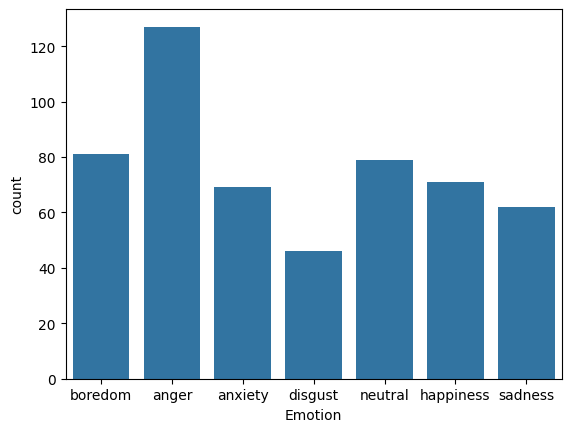

In [6]:
sns.countplot(data=emodb_df, x='Emotion')

In [7]:
# Feature extraction function with MFCC
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Extract MFCC features
X_mfcc = np.array([extract_mfcc(path) for path in tqdm(emodb_df['Path'], desc="Extracting MFCCs")])
X_mfcc.shape


Extracting MFCCs: 100%|██████████| 535/535 [00:03<00:00, 141.44it/s]


(535, 40)

In [8]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=20)  # Reducing to 20 components for efficiency
X_pca = pca.fit_transform(X_mfcc)



# Reshape data for LSTM input
X = np.expand_dims(X_pca, -1)
X.shape


(535, 20, 1)

In [9]:
# One-hot encode labels
enc = OneHotEncoder()
y = enc.fit_transform(emodb_df[['Emotion']]).toarray()
y.shape


(535, 7)

In [10]:
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], 1), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(emotion_codes), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[AUC(name="auc")])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,271 (294.03 KB)

 Trainable params: 75,271 (294.03 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.5374 - loss: 1.9330 - val_auc: 0.5487 - val_loss: 1.9245
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6376 - loss: 1.8593 - val_auc: 0.5410 - val_loss: 1.9806
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6475 - loss: 1.8411 - val_auc: 0.5539 - val_loss: 1.9637
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6626 - loss: 1.8093 - val_auc: 0.5834 - val_loss: 1.9260
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6967 - loss: 1.7733 - val_auc: 0.6097 - val_loss: 1.9218
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7163 - loss: 1.7252 - val_auc: 0.6409 - val_loss: 1.9157
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7665 - loss: 1.5952 - val_auc: 0.6912 - val_loss: 1.8233
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7939 - loss: 1.5321 - val_auc: 0.7087 - val_loss: 1.8131
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8224 - loss: 1.4329 - 

In [12]:
# Predict probabilities for test data and calculate AUC-ROC

y_pred_proba = model.predict(X)
y_true = y
auc_roc = roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovr")

print(f"AUC-ROC Score (Macro-Averaged): {auc_roc}")



# Optional: Classification Report
y_pred = np.argmax(y_pred_proba, axis=1)
y_true_classes = np.argmax(y_true, axis=1)
report = classification_report(y_true_classes, y_pred, target_names=enc.categories_[0])
print("Classification Report:")
print(report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
AUC-ROC Score (Macro-Averaged): 0.9271528900926043
Classification Report:
              precision    recall  f1-score   support

       anger       0.67      0.81      0.73       127
     anxiety       0.72      0.48      0.57        69
     boredom       0.60      0.70      0.65        81
     disgust       0.53      0.43      0.48        46
   happiness       0.56      0.56      0.56        71
     neutral       0.69      0.62      0.65        79
     sadness       0.75      0.73      0.74        62

    accuracy                           0.65       535
   macro avg       0.65      0.62      0.63       535
weighted avg       0.65      0.65      0.64       535



In [13]:
model.save('AUC-ROC.h5')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


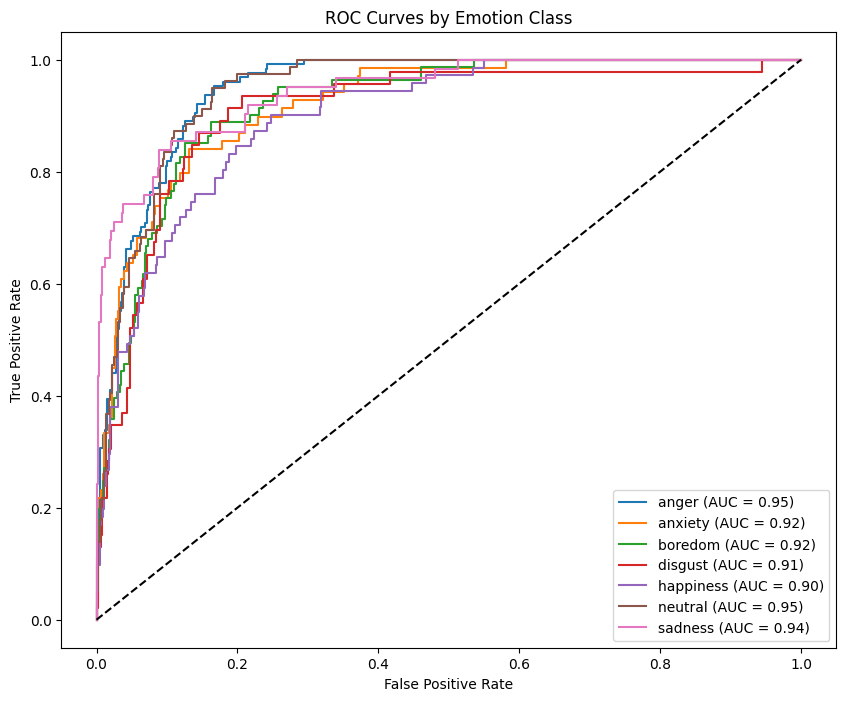

In [14]:
# Predict probabilities and plot ROC curves for each emotion class
y_pred_proba = model.predict(X)

plt.figure(figsize=(10, 8))
for i, emotion in enumerate(enc.categories_[0]):
    fpr, tpr, _ = roc_curve(y[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{emotion} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Emotion Class")
plt.legend(loc="lower right")
plt.show()


In [27]:
# Load the saved model
model = load_model("AUC-ROC.h5")

# Function to extract features from new .wav files and predict emotions
def predict_emotion_on_new_file(filepath):
    # Extract MFCC and apply PCA
    mfcc_features = extract_mfcc(filepath).reshape(1, -1)
    pca_features = pca.transform(mfcc_features)
    pca_features = np.expand_dims(pca_features, -1)

    # Predict probabilities
    predictions = model.predict(pca_features)
    predicted_emotion = enc.categories_[0][np.argmax(predictions)]
    return predicted_emotion, predictions

new_files = ['/Users/omedbahtuchi/Downloads/Neue-Aufnahme.wav']
for file in new_files:
    emotion, proba = predict_emotion_on_new_file(file)
    print(f"File: {file}")
    print(f"Predicted Emotion: {emotion}")
    print("Probabilities:")
    for emotion, probability in zip(enc.categories_[0], proba[0]):
        print(f" {emotion}: {probability}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
File: /Users/omedbahtuchi/Downloads/Neue-Aufnahme.wav
Predicted Emotion: anger
Probabilities:
 anger: 0.37603259086608887
 anxiety: 0.19542908668518066
 boredom: 0.14348046481609344
 disgust: 0.15427324175834656
 happiness: 0.009206130169332027
 neutral: 0.11583703011274338
 sadness: 0.005741390399634838


In [26]:
def predict_emotions_over_time(filepath, segment_duration=2.0, overlap=1.0):
    # Load audio file
    y, sr = librosa.load(filepath)
    
    # Calculate number of samples per segment
    segment_samples = int(segment_duration * sr)
    overlap_samples = int(overlap * sr)
    
    # Initialize an empty list to store results
    results = []
    
    # Process each segment
    for start in range(0, len(y) - segment_samples + 1, segment_samples - overlap_samples):
        # Extract segment
        segment = y[start:start + segment_samples]
        
        # Extract MFCC and apply PCA
        mfcc_features = np.mean(librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=40).T, axis=0).reshape(1, -1)
        pca_features = pca.transform(mfcc_features)
        pca_features = np.expand_dims(pca_features, -1)
        
        # Predict emotion probabilities
        predictions = model.predict(pca_features)
        predicted_emotion = enc.categories_[0][np.argmax(predictions)]
        
        # Calculate the timestamp for the segment
        start_time = start / sr
        end_time = (start + segment_samples) / sr
        
        # Append results
        results.append({
            "start_time": start_time,
            "end_time": end_time,
            "predicted_emotion": predicted_emotion,
            "probabilities": predictions[0]
        })

    return results

# Example usage
results = predict_emotions_over_time('/Users/omedbahtuchi/Downloads/Neue-Aufnahme.wav')
for res in results:
    print(f"From {res['start_time']:.2f}s to {res['end_time']:.2f}s: {res['predicted_emotion']} (Probabilities: {res['probabilities']})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
From 0.00s to 2.00s: boredom (Probabilities: [0.05054112 0.09723244 0.38917637 0.1409585  0.00285332 0.303432
 0.01580624])
From 1.00s to 3.00s: boredom (Probabilities: [0.03028118 0.11363636 0.45201713 0.13544843 0.00241714 0.25415328
 0.01204638])
From 2.00s to 4.00s: anger (Probabilities: [8.9130843e-01 6.4959422e-02 5.3553451e-03 2.4221839e-02 6.2968200e-03
 7.4806758e-03 3.7744816e-04])
From 3.00s to 5.00s: boredom (Probabilities: [7.8802528e-03 1.4311188e-02 7.2471952e-01 1.2426331e-02 5.2977807e-04
 2.3158771e-01 8.5452776e-03])
From 4.00s to 6.00s: anger (Probabilities: [0.35969198 0.19942622 0.22597301 0.08177237 0.00821938 0.11908644
 0.00583064])
